In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#mpl.rcParams['figure.dpi'] = 100
random_state = 42
sns.reset_defaults()

In [ ]:
# Read data
df = pd.read_csv('earthquake_data_tsunami.csv')
print(df.shape)
print(df.dtypes)
print(df.head())

(782, 13)
magnitude    float64
cdi            int64
mmi            int64
sig            int64
nst            int64
dmin         float64
gap          float64
depth        float64
latitude     float64
longitude    float64
Year           int64
Month          int64
tsunami        int64
dtype: object
   magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11        1  
4  2022     11        1  


tsunami
0    478
1    304
Name: count, dtype: int64


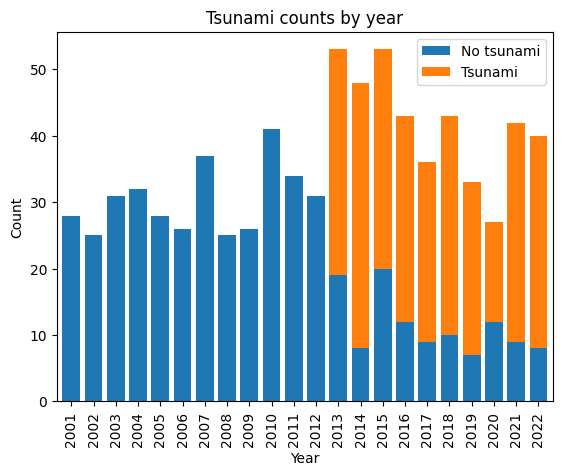

In [ ]:
# Plot tsunami counts by year
tsunami_counts = df['tsunami'].value_counts()
print(tsunami_counts)

tsunami_counts_by_year = df.groupby('Year')['tsunami'].value_counts().unstack().fillna(0)
tsunami_counts_by_year.plot(kind='bar', stacked=True, width=0.8)
plt.title('Tsunami counts by year')
plt.ylabel('Count')
plt.legend(['No tsunami', 'Tsunami'])
plt.show()

# Plot distribution

## Data Preprocessing

In [ ]:
# Stratified train/test/valid split
X = df.drop(['tsunami', 'Year', 'Month'], axis=1)
y = df['tsunami']

# 70/15/15 train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y,
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp,
)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print()
print("Tsunami ratio")
print(f"Train set: {y_train.value_counts(normalize=True)[1]}")
print(f"Valid set: {y_valid.value_counts(normalize=True)[1]}")
print(f"Test set:  {y_test.value_counts(normalize=True)[1]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid) # apply same scaling for valid and test set
X_test_scaled = scaler.transform(X_test)
print(f"Mean of X_train_scaled:  {X_train_scaled.mean():.6f}")
print(f"Standard deviation of X_train_scaled:  {X_train_scaled.std():.6f}")


X_train: (547, 10)
y_train: (547,)
X_valid: (117, 10)
y_valid: (117,)
X_test: (118, 10)
y_test: (118,)

Tsunami ratio
Train set: 0.38939670932358317
Valid set: 0.38461538461538464
Test set:  0.3898305084745763
Mean of X_train_scaled:  -0.000000
Standard deviation of X_train_scaled:  1.000000


# Logistic Regression

In [ ]:
# function fo evaluating model
def evaluate_model(model, X, y_true, data_name, confusion, model_name):
    # Predictions
    y_pred = model.predict(X)
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X)
    elif hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1] # Probability of Class 1
    else:
        raise AttributeError("Model does not support probability or decision function.")

    # Accuracy metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)

    print("="*40)
    print(data_name)
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 score: {f1:.6f}")
    print(f"ROC AUC score: {roc_auc:.6f}")

    # Draw confusion matrix
    if confusion == "y":
        confusion = confusion_matrix(y_true, y_pred)
        print(f"Confusion matrix for {data_name}")
        print(f"TN: {confusion[0, 0]:>4}   FP: {confusion[0, 1]:>4}")
        print(f"FN: {confusion[1, 0]:>4}   TP: {confusion[1, 1]:>4}")

        plt.figure(figsize=(4,4))
        ax = sns.heatmap(confusion, annot=True, annot_kws={"fontsize": 18}, fmt="d", cmap="Blues", cbar=False)
        ax.set_title(f"Confusion Matrix: {model_name}")
        ax.set_xticklabels(['No tsunami', 'Tsunami'])
        ax.set_yticklabels(['No tsunami', 'Tsunami'])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        plt.show()

A baseline model is first tested without any regularization. The model has an accuracy of 0.8223 and recall of 0.8696 on the test set.

Train set
Accuracy: 0.822669
Precision: 0.714815
Recall: 0.906103
F1 score: 0.799172
ROC AUC score: 0.890697
Valid set
Accuracy: 0.803419
Precision: 0.689655
Recall: 0.888889
F1 score: 0.776699
ROC AUC score: 0.871296
Test set
Accuracy: 0.788136
Precision: 0.677966
Recall: 0.869565
F1 score: 0.761905
ROC AUC score: 0.820652
Confusion matrix for Test set
TN:   53   FP:   19
FN:    6   TP:   40


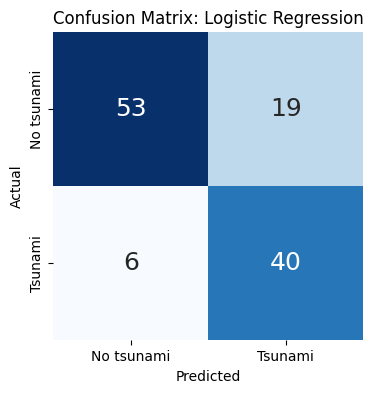

In [ ]:
# class_weight = 'balanced': address class imbalance problem
# C inverse of regularization strength, smaller values has stronger regularization
# Baseline model

model = LogisticRegression(penalty=None, random_state=random_state,
                           max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

evaluate_model(model, X_train_scaled, y_train, "Train set", "n", "Logistic Regression")
evaluate_model(model, X_valid_scaled, y_valid, "Valid set", "n", "Logistic Regression")
evaluate_model(model, X_test_scaled, y_test, "Test set", "y", "Logistic Regression")

A grid search with 5-fold stratified cross validation was performed to find the best combination of penalty type (L1, L2) and regularization strength with recall as the evaluation metric.
- The C parameter represent the inverse of regularization strength. A smaller C value represent a stronger regularization strength.

The best parameters found were penalty=L1 with C=0.01. The model has a test accuracy of 0.7966 and  recall of 0.913.



Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Score: 0.8081042265266911
Train set
Accuracy: 0.829982
Precision: 0.715827
Recall: 0.934272
F1 score: 0.810591
ROC AUC score: 0.871581
Valid set
Accuracy: 0.811966
Precision: 0.694915
Recall: 0.911111
F1 score: 0.788462
ROC AUC score: 0.851852
Test set
Accuracy: 0.788136
Precision: 0.672131
Recall: 0.891304
F1 score: 0.766355
ROC AUC score: 0.777174
Confusion matrix for Test set
TN:   52   FP:   20
FN:    5   TP:   41


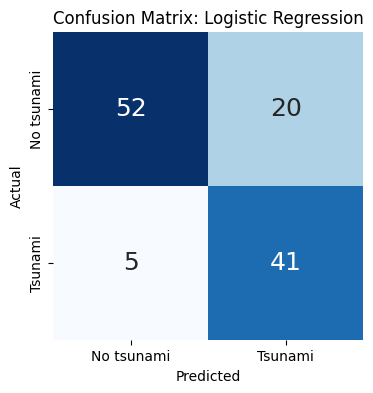

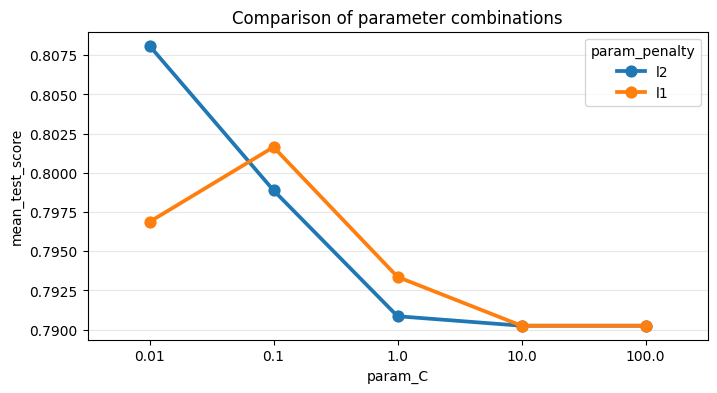

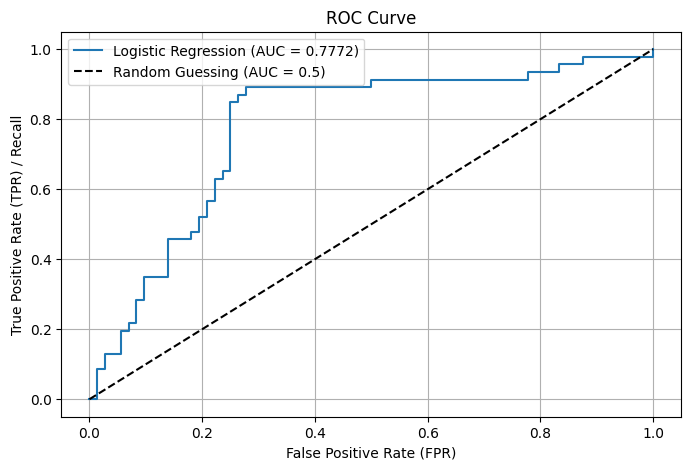

In [ ]:
# Search for best parameter combinations
# Gridsearch with 5-fold cross validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

gs = GridSearchCV(
    estimator=LogisticRegression(random_state=random_state, solver='liblinear',
                                 max_iter=1000, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)

gs.fit(X_train_scaled, y_train)

# Evaluate the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
model = gs.best_estimator_

evaluate_model(model, X_train_scaled, y_train, "Train set", "n", "Logistic Regression")
evaluate_model(model, X_valid_scaled, y_valid, "Valid set", "n", "Logistic Regression")
evaluate_model(model, X_test_scaled, y_test, "Test set", "y", "Logistic Regression")

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_penalty", "param_C", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(8,4))
ax = sns.pointplot(results, x="param_C", y="mean_test_score", hue="param_penalty")
ax.set_title("Comparison of parameter combinations")
ax.grid(axis="y", alpha=0.3)
plt.show()

# Plot ROC-AUC curve
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Train set
Accuracy: 0.829982
Precision: 0.717391
Recall: 0.929577
F1 score: 0.809816
ROC AUC score: 0.884513
Valid set
Accuracy: 0.811966
Precision: 0.694915
Recall: 0.911111
F1 score: 0.788462
ROC AUC score: 0.861111
Test set
Accuracy: 0.788136
Precision: 0.672131
Recall: 0.891304
F1 score: 0.766355
ROC AUC score: 0.796498
Confusion matrix for Test set
TN:   52   FP:   20
FN:    5   TP:   41


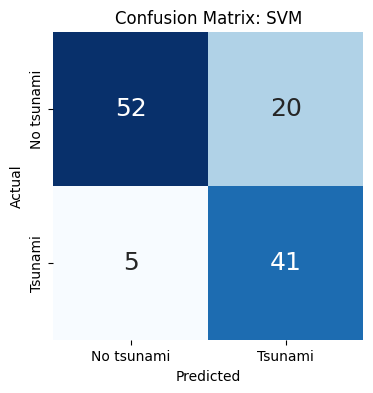

/tmp/ipython-input-1258249095.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guessing (AUC = 0.5)')


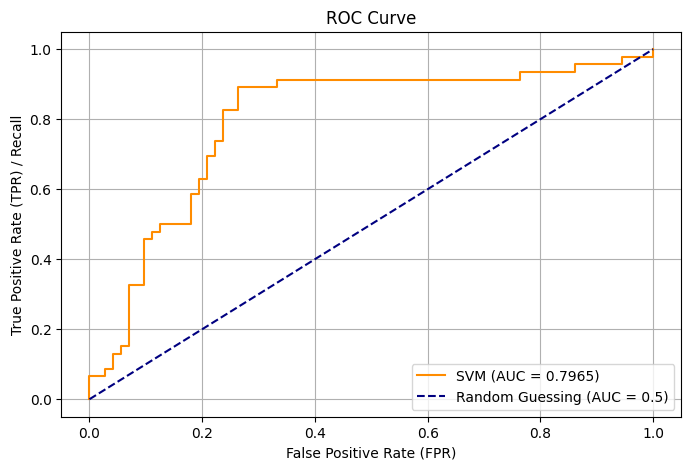

In [ ]:
model = SVC(random_state=42, C=1, gamma=0.01, kernel='rbf')

model.fit(X_train_scaled, y_train)

evaluate_model(model, X_train_scaled, y_train, "Train set", "n", "SVM")
evaluate_model(model, X_valid_scaled, y_valid, "Valid set", "n", "SVM")
evaluate_model(model, X_test_scaled, y_test, "Test set", "y", "SVM")


# Plot ROC-AUC curve
if hasattr(model, "decision_function"):
    y_scores = model.decision_function(X_test_scaled)
elif hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(X_test_scaled)[:, 1] # Probability of Class 1
else:
    raise AttributeError("Model does not support probability or decision function.")

auc_score = roc_auc_score(y_test, y_scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'SVM (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guessing (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## Feature Importance
nst (Number of seismic monitoring stations) has the strongest negative correlation, while dmin (distance to nearest seismic station), cdi (Community Decimal Intensity (felt intensity)) has relatively strong positive correlations.

In [ ]:
# Feature importance
importance = model.coef_
features = X.columns
for i in range(len(features)):
    print(f"{features[i]}: {importance[0][i]:.6f}")